In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
from collections import defaultdict

In [21]:
# Define the log directories
log_dir = '../logs/resnet18'
cifar10_dir = os.path.join(log_dir, 'cifar10')
imagenet_dir = os.path.join(log_dir, 'imagenet')
cifar100_dir = '../../pytorch-cifar100/logs/resnet18/cifar100/'

In [22]:
def parse_filename(filename):
    """
    Parses the filename to extract algorithm, hyperparameters, and seed.
    
    Args:
        filename (str): The name of the file.
    
    Returns:
        tuple: (algorithm (str), hyperparams (dict), seed (int), rescale (bool))
    """
    # Remove the file extension
    name = filename.split('.csv')[0]
    
    # Split the name by underscores
    parts = name.split('_')
    
    # The first part is the algorithm
    algorithm = parts[0]
    
    hyperparams = {}
    seed = None

    # Regular expression to match key-value pairs (e.g., lr0.1, bs128, rf10)
    pattern = re.compile(r'([a-zA-Z]+)([\d.]+)')

    for part in parts[1:]:
        # Check if the part is 'rescale'
        hyperparams['rescale'] = False
        if part == 'rescale':
            hyperparams['rescale'] = True
        # Check if the part represents a seed (e.g., s1)
        elif part.startswith('s') and part[1:].isdigit():
            seed = int(part[1:])
        # Check for key-value pairs (e.g., lr0.1, bs128)
        else:
            match = pattern.match(part)
            if match:
                key, value = match.groups()
                hyperparams[key] = value
        
    
    return algorithm, hyperparams, seed


def extract_numeric_from_tensor_string(s):
    """
    Extracts the numeric value from a string formatted like "tensor(1.1200, device='cuda:0')"
    or returns the value directly if it's already a numeric type.
    
    Args:
        s (str or float or int): The input value from the 'val_acc' column.
    
    Returns:
        float: The extracted numeric value, or NaN if extraction fails.
    """
    # If the input is already a numeric type, return it as a float
    if isinstance(s, (int, float)):
        return float(s)
    
    # If the input is a string, attempt to extract the numeric value
    elif isinstance(s, str):
        # Define a regex pattern to capture the number inside 'tensor(...)'
        pattern = r'tensor\(([\d.]+),'
        match = re.search(pattern, s)
        if match:
            try:
                return float(match.group(1))
            except ValueError:
                # In case the captured group is not a valid float
                return float('nan')
        else:
            # Attempt to convert the string directly to float if it doesn't match the pattern
            try:
                return float(s)
            except ValueError:
                return float('nan')
    
    # For any other data types, return NaN
    else:
        return float('nan')



def validate_val_acc(algorithm, hyperparam_str, summary_df):
    """
    Validates that val_acc_mean values are within the expected range (0-100).
    Prints anomalies if found.

    Args:
        algorithm (str): The algorithm name.
        hyperparam_str (str): The hyperparameter string.
        summary_df (pd.DataFrame): The summary DataFrame with aggregated metrics.
        dataset_name (str): Name of the dataset for logging purposes.

    Returns:
        None
    """
    # Check if 'val_acc_mean' exists
    if 'val_acc_mean' not in summary_df.columns:
        print(f"'val_acc_mean' column missing for algorithm '{algorithm}' with hyperparameters '{hyperparam_str}' in {dataset_name}.")
        return

    # Identify rows where 'val_acc_mean' is outside [0, 100]
    invalid_vals = summary_df[
        (summary_df['val_acc_mean'] < 0) | (summary_df['val_acc_mean'] > 100)
    ]


    if not invalid_vals.empty:
        print(f"'val_acc_mean' values outside [0, 100] for algorithm '{algorithm}' with hyperparameters '{hyperparam_str}'")


def process_directory(directory):
    """
    Processes the given directory to compute average validation accuracies.

    Args:
        directory (str): Path to the directory containing CSV files.

    Returns:
        dict: average_acc_dict[algorithm][hyperparam_str] = pd.Series of averaged val_acc
        Additionally, prints out any hyperparam configs missing seeds 1..5 and non-numeric val_acc entries.
    """
    # We'll store data as data_groups[algorithm][hyperparam_str][seed] = df
    data_groups = defaultdict(lambda: defaultdict(dict))

    # ---------------------------
    # Read all CSVs
    # ---------------------------
    imgnet_columns = [ 
    'epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc1', 'val_acc5',
    'learning_rate', 'batch_size', 'epoch_time', 'eval_time', 
    'abs_time', 'memory_allocated_mb', 'memory_reserved_mb', 'grad_diversity'
    ]


    for filename in os.listdir(directory):
        if not filename.endswith('.csv'):
            continue
        # Parse filename to extract components
        algorithm, hyperparams, seed= parse_filename(filename)
        # print(f"Processing '{filename}': {algorithm}, {hyperparams}, {seed}")

        # Build a consistent hyperparam_str
        hyperparam_items = hyperparams.items()
        hyperparam_str = '_'.join([f"{k}{v}" for k, v in hyperparam_items])

        # If there's no seed in the file name, skip or handle differently
        if seed is None:
            print(f"Warning: No seed found in filename '{filename}'. Skipping.")
            continue

        file_path = os.path.join(directory, filename)
        # Read the first row to check for a header
        with open(file_path, 'r') as file:
            first_line = file.readline().strip().split(',')
            
        # Check if the first line matches the expected header
        if 'epoch' not in first_line:
            df = pd.read_csv(file_path, header=None, names=imgnet_columns)
        else:
            df = pd.read_csv(file_path)
        


        # print(f"{filename} - val_acc dtype: {df['val_acc'].dtype}")

        # 2.1) SHIFT + REWRITE "epoch" if out of [0..199] or [1..200], etc.
        if "epoch" in df.columns:
            epoch_min, epoch_max = df["epoch"].min(), df["epoch"].max()
        else:
            epoch_min = epoch_max = -1
        if 'val_acc1' in df.columns:
            df.rename(columns={'val_acc1': 'val_acc'}, inplace=True)

        if 'sgd_' in filename:
            if 'grad_diversity' in df.columns:
                df.drop(columns=['grad_diversity'], inplace=True)


        last_col = df.iloc[:, -1]
        all_nan_last_col = last_col.isna().all()

        # Decide if epoch is invalid
        not_valid_epoch = not ((epoch_min == 0) or (epoch_min == 1))

        if all_nan_last_col and not_valid_epoch:
            df = df.shift(periods=1, axis=1)
            df["epoch"] = range(1, len(df) + 1)
            print(f"Shifted and rewrote 'epoch' column for '{filename}'")
            # print(df.head())



        df['val_acc'] = df['val_acc'].apply(extract_numeric_from_tensor_string)

        # if max(df['val_loss']) > 10:
        #     print(f"Warning: 'val_loss' values in '{filename}' are too high. Skipping.")
        #     print(df['val_loss'])
            

        non_numeric = pd.to_numeric(df['val_acc'], errors='coerce').isna()
        # if non_numeric.any():
        #     epochs_with_non_numeric = df.loc[non_numeric, 'epoch'].tolist()
        #     print(f"Warning: Non-numeric 'val_acc' entries in '{filename}' at epochs {epochs_with_non_numeric}. These will be set to NaN.")
        # Identify non-numeric 'val_acc' entries
        non_numeric_val_acc = df[df['val_acc'].isna()]
        # if not non_numeric_val_acc.empty:
        #     print(f"[WARNING] Non-numeric 'val_acc' entries found in '{filename}':")
        #     print(non_numeric_val_acc)

        # Optionally, handle missing 'val_acc' values
        # Example: Drop rows where 'val_acc' is NaN
        # df.dropna(subset=['val_acc'], inplace=True)

        # Check for duplicate 'epoch' values
        duplicate_epochs = df['epoch'][df['epoch'].duplicated()].unique()
        if len(duplicate_epochs) > 0:
            # print(f"[WARNING] Duplicate 'epoch' values found in '{filename}': {duplicate_epochs}")
            # Optionally, keep the first occurrence and drop duplicates
            df = df.drop_duplicates(subset=['epoch'], keep='first')

        # OPTIONAL: Sort by epoch so the final index is in ascending order
        df.sort_values("epoch", inplace=True)

        # 2.2) Store the DataFrame in our dictionary
        data_groups[algorithm][hyperparam_str][seed] = df

        # except Exception as e:
        #     print(f"Error reading '{filename}': {e}")

    # Compute the average val_acc across seeds
    # ---------------------------
    average_acc_dict = defaultdict(dict)

    for algorithm, hyperparams_dict in data_groups.items():
        for hyperparam_str, seeds_dict in hyperparams_dict.items():
            # Check for missing seeds (assuming seeds 1 to 5)
            expected_seeds = set(range(1, 6))
            present_seeds = set(seeds_dict.keys())
            missing_seeds = expected_seeds - present_seeds
            if missing_seeds:
                print(f"Warning: Missing seeds {sorted(missing_seeds)} for algorithm '{algorithm}' with hyperparameters '{hyperparam_str}'.")

            # Collect all dataframes for available seeds
            dfs = []
            for seed in sorted(seeds_dict.keys()):
                df = seeds_dict[seed].copy()
                df['seed'] = seed
                dfs.append(df)

            # if not dfs:
            #     print(f"Warning: No data available for algorithm '{algorithm}' with hyperparameters '{hyperparam_str}'. Skipping.")
            #     continue

            # Concatenate all dataframes
            combined_df = pd.concat(dfs, ignore_index=True)

            # Group by epoch
            grouped = combined_df.groupby('epoch')

            # Compute mean and SEM for val_acc and val_loss
            summary_df = grouped.agg(
                val_acc_mean=('val_acc', 'mean'),
                val_acc_sem=('val_acc', 'sem'),
                val_loss_mean=('val_loss', 'mean'),
                val_loss_sem=('val_loss', 'sem')
            ).reset_index()
            validate_val_acc(algorithm, hyperparam_str, summary_df)
            average_acc_dict[algorithm][hyperparam_str] = summary_df

    return average_acc_dict

# Process the CIFAR-10 directory
average_acc_cifar100 = process_directory(cifar100_dir)
average_acc_cifar10 = process_directory(cifar10_dir)
average_acc_imagenet = process_directory(imagenet_dir)

Shifted and rewrote 'epoch' column for 'divebatch_lr0.1_bs128_rf10_mbs2048_delta0.1_s4_rescale.csv'
Shifted and rewrote 'epoch' column for 'divebatch_lr0.1_bs128_rf10_mbs2048_delta0.1_s5.csv'
Shifted and rewrote 'epoch' column for 'divebatch_lr0.1_bs128_rf10_mbs2048_delta0.1_s5_rescale.csv'
Shifted and rewrote 'epoch' column for 'divebatch_lr0.1_bs128_rf20_mbs2048_delta0.1_s4.csv'
Shifted and rewrote 'epoch' column for 'divebatch_lr0.1_bs128_rf20_mbs2048_delta0.1_s4_rescale.csv'
Shifted and rewrote 'epoch' column for 'divebatch_lr0.1_bs128_rf20_mbs2048_delta0.1_s5.csv'
Shifted and rewrote 'epoch' column for 'divebatch_lr0.1_bs128_rf20_mbs2048_delta0.1_s5_rescale.csv'
Shifted and rewrote 'epoch' column for 'sgd_lr0.16_bs2048_s1.csv'
Shifted and rewrote 'epoch' column for 'sgd_lr0.1_bs128_s2.csv'


/tmp/ipykernel_47558/1696990265.py:257: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(dfs, ignore_index=True)
/tmp/ipykernel_47558/1696990265.py:257: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(dfs, ignore_index=True)
/tmp/ipykernel_47558/1696990265.py:257: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the

In [26]:
def split_data_by_rescale(average_acc_dict):
    """
    Splits the data into two groups based on 'rescaleTrue' and 'rescaleFalse'.
    Ensures that all entries with the 'sgd' algorithm are included in both groups.

    Args:
        average_acc_dict (dict): The dictionary containing average accuracies.
    
    Returns:
        dict: Two dictionaries, one for each group.
    """
    rescale_true = defaultdict(dict)
    rescale_false = defaultdict(dict)

    for algorithm, hyperparams_dict in average_acc_dict.items():
        for hyperparam_str, summary_df in hyperparams_dict.items():
            # Check the 'rescale' value in the hyperparameters
            if 'rescaleTrue' in hyperparam_str:
                rescale_true[algorithm][hyperparam_str] = summary_df
                if algorithm == 'sgd':  # Include all 'sgd' entries
                    rescale_false[algorithm][hyperparam_str] = summary_df
            elif 'rescaleFalse' in hyperparam_str:
                rescale_false[algorithm][hyperparam_str] = summary_df
                if algorithm == 'sgd':  # Include all 'sgd' entries
                    rescale_true[algorithm][hyperparam_str] = summary_df

    return rescale_true, rescale_false

# Split the data
# rescale_true_data, rescale_false_data = split_data_by_rescale(average_acc_cifar100)
rescale_true_data, rescale_false_data = split_data_by_rescale(average_acc_cifar10)
# rescale_true_data, rescale_false_data = split_data_by_rescale(average_acc_imagenet)


In [27]:
def split_data_by_resize_freq(data_dict):
    """
    Splits the data further by 'resize_freq' (denoted as 'rf' in the hyperparameter string).

    Args:
        data_dict (dict): The dictionary containing rescale-split data.
    
    Returns:
        dict: Nested dictionaries with data grouped by resize_freq.
    """
    # Dictionary to hold data split by resize_freq
    resize_freq_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

    for algorithm, hyperparams_dict in data_dict.items():
        for hyperparam_str, summary_df in hyperparams_dict.items():
            # Extract the resize_freq (rf) value from the hyperparam_str
            rf_match = re.search(r'rf(\d+)', hyperparam_str)
            if rf_match:
                resize_freq = int(rf_match.group(1))
            else:
                # If 'rf' is not found, assign a default value (e.g., -1 or 'None')
                resize_freq = -1
            
            # Organize data by algorithm, resize_freq, and hyperparam_str
            resize_freq_dict[resize_freq][algorithm][hyperparam_str] = summary_df

    return resize_freq_dict

# Apply the function to the rescale-split data
rescale_true_by_rf = split_data_by_resize_freq(rescale_true_data)
rescale_false_by_rf = split_data_by_resize_freq(rescale_false_data)


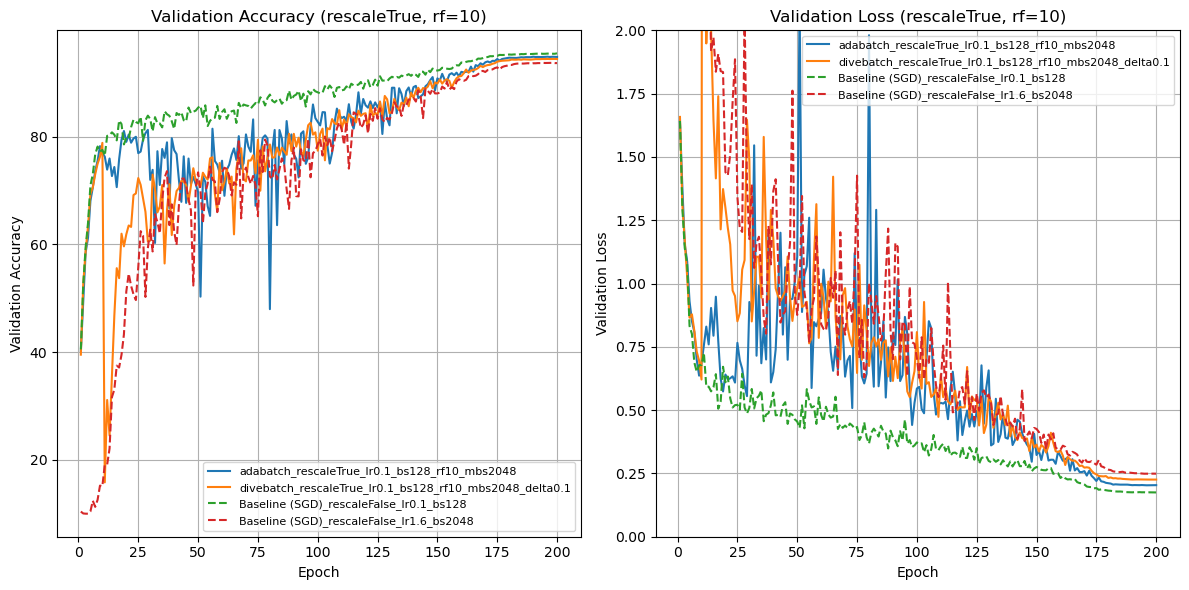

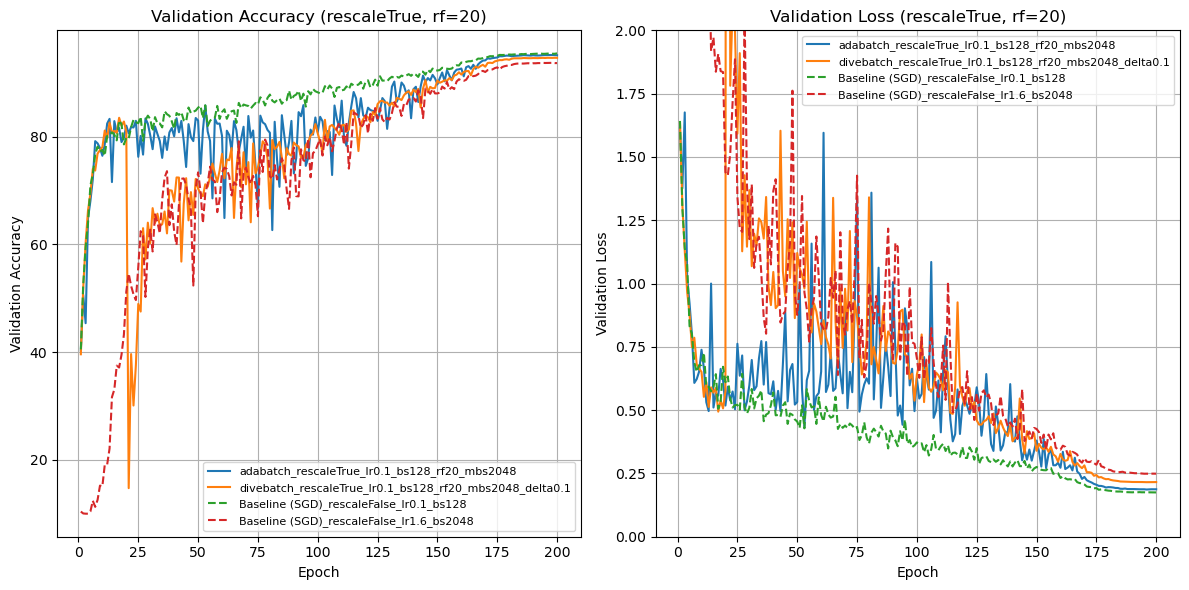

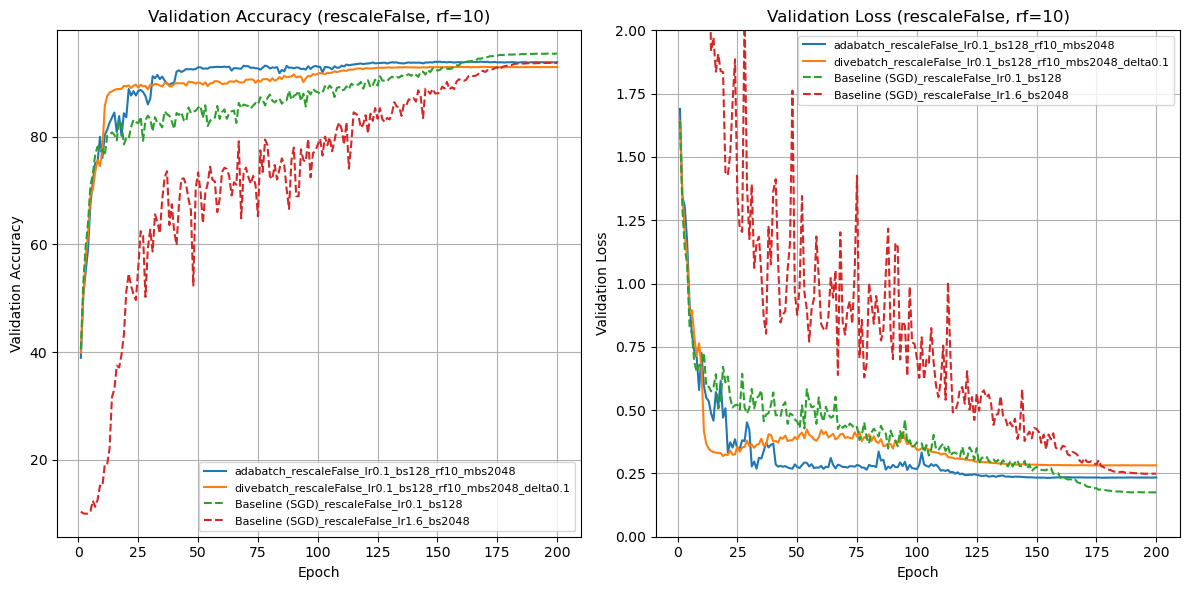

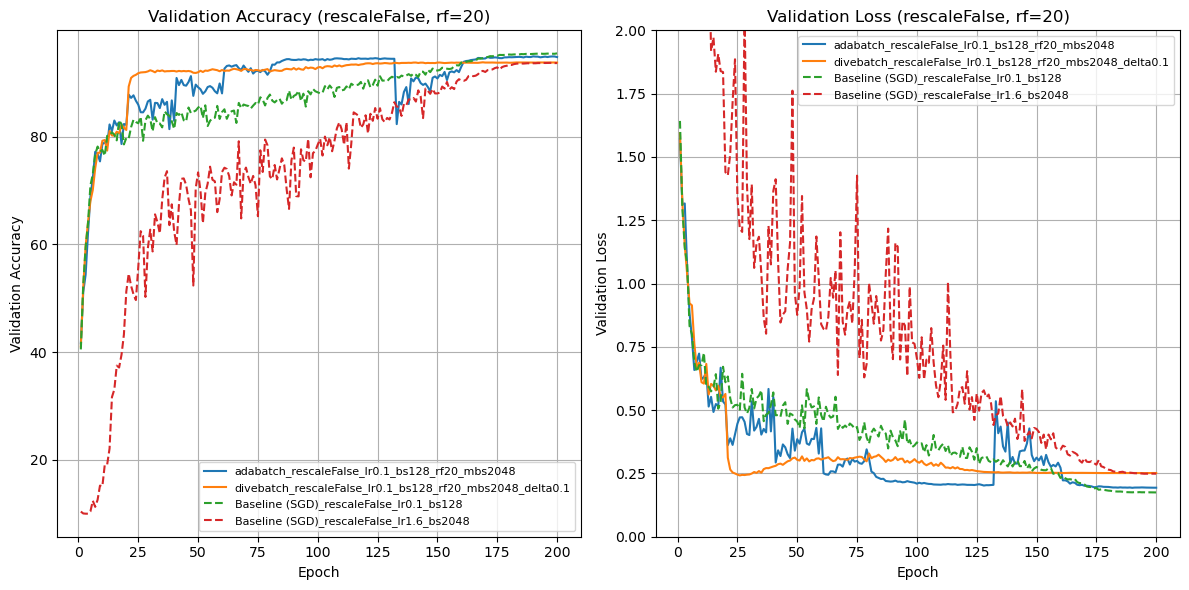

In [28]:
def plot_val_acc_and_loss_with_baseline(rescale_dict, rescale_status, filter_hyperparams=None):
    """
    Plots validation accuracy and loss for each (rescale_status, rf) pair,
    ensuring that 'SGD' algorithm is included as a baseline in all plots.

    Args:
        rescale_dict (dict): The dictionary split by `resize_freq` (rf).
        rescale_status (str): Either 'rescaleTrue' or 'rescaleFalse' for labeling purposes.

    Returns:
        None
    """
    for rf, algorithm_dict in rescale_dict.items():
        if rf == -1:
            continue
        plt.figure(figsize=(12, 6))
        
        # Subplot for validation accuracy
        plt.subplot(1, 2, 1)
        
        # Plot all algorithms for this rf
        for algorithm, hyperparams_dict in algorithm_dict.items():
            for hyperparam_str, summary_df in hyperparams_dict.items():
                if filter_hyperparams and not filter_hyperparams(hyperparam_str):
                    continue
                plt.plot(
                    summary_df['epoch'], 
                    summary_df['val_acc_mean'], 
                    label=f"{algorithm}_{hyperparam_str}"
                )
        
        # Add 'SGD' baselines to the accuracy plot
        for algorithm, hyperparams_dict in rescale_dict.get(-1, {}).items():
            if algorithm.lower() == 'sgd':
                for hyperparam_str, summary_df in hyperparams_dict.items():
                    if filter_hyperparams and not filter_hyperparams(hyperparam_str):
                        continue
                    plt.plot(
                        summary_df['epoch'], 
                        summary_df['val_acc_mean'], 
                        linestyle='--', 
                        label=f"Baseline (SGD)_{hyperparam_str}"
                    )
        
        plt.title(f"Validation Accuracy ({rescale_status}, rf={rf})")
        plt.xlabel("Epoch")
        plt.ylabel("Validation Accuracy")
        plt.legend(loc="best", fontsize=8)
        plt.grid()

        # Subplot for validation loss
        plt.subplot(1, 2, 2)
        
        # Plot all algorithms for this rf
        for algorithm, hyperparams_dict in algorithm_dict.items():
            for hyperparam_str, summary_df in hyperparams_dict.items():
                if filter_hyperparams and not filter_hyperparams(hyperparam_str):
                    continue
                plt.plot(
                    summary_df['epoch'], 
                    summary_df['val_loss_mean'], 
                    label=f"{algorithm}_{hyperparam_str}"
                )
        
        # Add 'SGD' baselines to the loss plot
        for algorithm, hyperparams_dict in rescale_dict.get(-1, {}).items():
            if algorithm.lower() == 'sgd':

                for hyperparam_str, summary_df in hyperparams_dict.items():
                    if filter_hyperparams and not filter_hyperparams(hyperparam_str):
                        continue
                    plt.plot(
                        summary_df['epoch'], 
                        summary_df['val_loss_mean'], 
                        linestyle='--', 
                        label=f"Baseline (SGD)_{hyperparam_str}"
                    )
        
        plt.title(f"Validation Loss ({rescale_status}, rf={rf})")
        plt.xlabel("Epoch")
        plt.ylabel("Validation Loss")
        plt.ylim(0, 2)
        plt.legend(loc="best", fontsize=8)
        plt.grid()

        # Show the plots for the current (rescale_status, rf) pair
        plt.tight_layout()
        plt.show()


filter_hyperparams_10 = lambda hp_str: ('4096' not in hp_str) and ('0.16' not in hp_str) and not('lr0.1_bs2048' in hp_str) and not('1.6' in hp_str and '128' in hp_str) and (hp_str.endswith('delta0.1') or 'delta' not in hp_str)
filter_hyperparams_100 = lambda hp_str: ('4096' not in hp_str) and ('0.16' not in hp_str) and not('lr0.1_bs2048' in hp_str) and not('1.6' in hp_str and '128' in hp_str) 
filter_hyperparams_imagenet = lambda hp_str: True
# Plot for rescaleTrue data with SGD baselines

plot_val_acc_and_loss_with_baseline(rescale_true_by_rf, "rescaleTrue", filter_hyperparams_10)

# Plot for rescaleFalse data with SGD baselines
plot_val_acc_and_loss_with_baseline(rescale_false_by_rf, "rescaleFalse", filter_hyperparams_10)